In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
!unzip "/content/gdrive/MyDrive/gdriveupmebot/archive.zip" -d "/tmp/data"

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib.image import imread
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Preprocessing

In [4]:
main_dir="/tmp/data/Brain Tumor Data Set/Brain Tumor Data Set/"

In [5]:
print("==========================Number of pictures")

for sub_dir in os.listdir(main_dir):
  print(sub_dir+": "+str(len(os.listdir(main_dir+sub_dir))))  

==========================Number of pictures
Brain Tumor: 2513
Healthy: 2087


In [6]:
sample=Image.open(main_dir+"Brain Tumor/Cancer (55).jpg")

(512, 512)
RGB


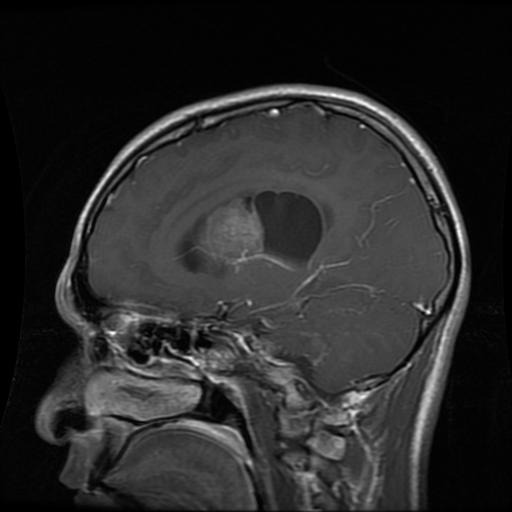

In [7]:
print(f'{sample.size}')
print(f'{sample.mode}')
sample

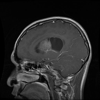

In [8]:
sample.resize((100,100))

In [9]:
subDir=["Brain Tumor", "Healthy"]

Storing data

In [10]:
data=[]

for i in range(2):
  for pic in os.listdir(main_dir+"/"+subDir[i]):
    data.append([Image.open(main_dir+"/"+subDir[i]+"/"+pic),i])

In [11]:
data[0]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=283x338 at 0x7EFDE2B7EF90>,
 0]

In [12]:
len(data)

4600

Manual Under Sampeling

In [13]:
balanced_data=data[426:]

In [14]:
len(balanced_data)

4174

In [15]:
width=[]
height=[]
channels=[]

for i in balanced_data:
  widtht, heightt= i[0].size

  width.append(widtht)
  height.append(heightt)
  channels.append(i[0].mode)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


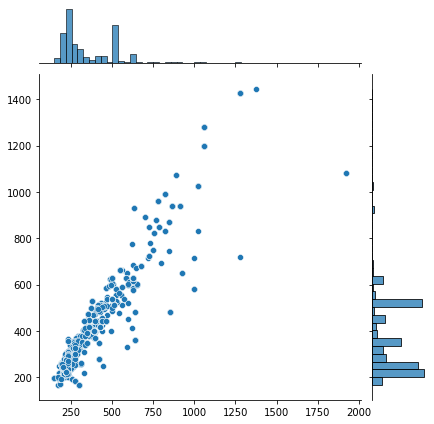

In [16]:
sns.jointplot(width, height)

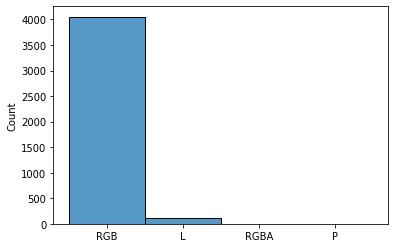

In [17]:
sns.histplot(channels)

In [18]:
width=0
height=0

for i in range(len(balanced_data)-1,-1,-1):
  width, height= balanced_data[i][0].size
  if ((width>1100) | (height>1100)):
    balanced_data.pop(i)

Resizing and converting to black and white

In [19]:
for i in range(len(balanced_data)):
  balanced_data[i][0]=np.asarray(balanced_data[i][0].resize((100,100)).convert("L")).astype("float32")

In [20]:
random.shuffle(balanced_data)

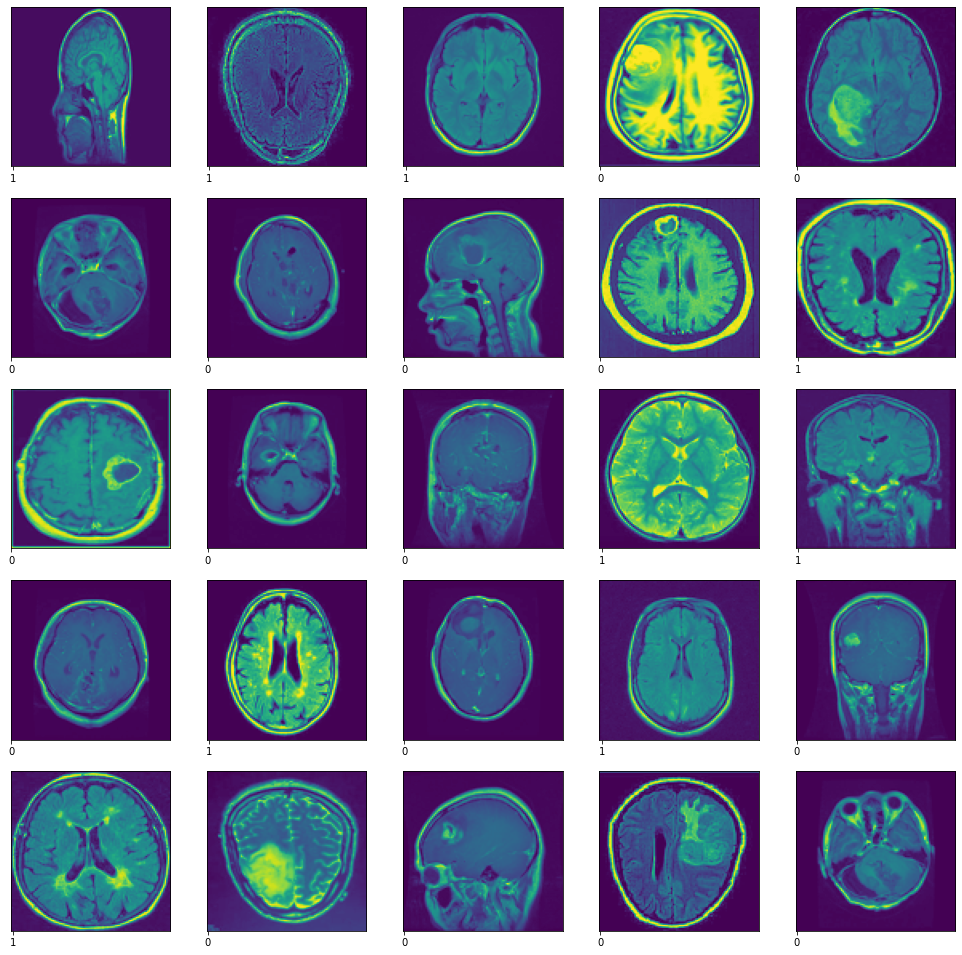

In [21]:
fig, ax = plt.subplots(5, 5, figsize=(17, 17))
n = 0
for i in range(5):
    for j in range(5):
        ax[i, j].set_xticks([balanced_data[n][1]])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(balanced_data[n][0])
        n += 1

# Model

In [22]:
xtrain, xtest, ytrain, ytest= train_test_split([np.divide(x[0],255) for x in balanced_data], [y[1] for y in balanced_data])

In [23]:
xtrain=np.array(xtrain).reshape(-1,100,100,1)

In [24]:
ytrain=to_categorical(ytrain)

In [25]:
es=EarlyStopping(patience=4)

In [47]:
model=Sequential()

model.add(Conv2D(32,(5,5), activation="relu"))
model.add(MaxPool2D(3,3))

model.add(Conv2D(32,(5,5), activation="relu"))
model.add(MaxPool2D(3,3))

model.add(Flatten())

model.add(Dense(32, activation="relu"))

model.add(Dense(2, activation="softmax"))


model.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer="rmsprop")

model.fit(xtrain, ytrain, validation_split=.2, epochs=1500,  callbacks=[es])

Epoch 1/1500
78/78 [==============================] - 2s 20ms/step - loss: 0.5884 - accuracy: 0.6778 - val_loss: 0.4940 - val_accuracy: 0.7605
Epoch 2/1500
78/78 [==============================] - 1s 17ms/step - loss: 0.4153 - accuracy: 0.8061 - val_loss: 0.4313 - val_accuracy: 0.8055
Epoch 3/1500
78/78 [==============================] - 1s 16ms/step - loss: 0.3345 - accuracy: 0.8681 - val_loss: 0.3899 - val_accuracy: 0.8376
Epoch 4/1500
78/78 [==============================] - 1s 16ms/step - loss: 0.2604 - accuracy: 0.8914 - val_loss: 0.2677 - val_accuracy: 0.8939
Epoch 5/1500
78/78 [==============================] - 1s 16ms/step - loss: 0.2017 - accuracy: 0.9220 - val_loss: 0.3384 - val_accuracy: 0.8617
Epoch 6/1500
78/78 [==============================] - 1s 16ms/step - loss: 0.1554 - accuracy: 0.9449 - val_loss: 0.2494 - val_accuracy: 0.8987
Epoch 7/1500
78/78 [==============================] - 1s 16ms/step - loss: 0.1164 - accuracy: 0.9610 - val_loss: 0.1962 - val_accuracy: 0.9260

# Evaluation

In [48]:
hist=pd.DataFrame(model.history.history)

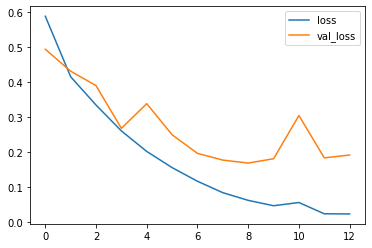

In [49]:
hist[["loss","val_loss"]].plot()

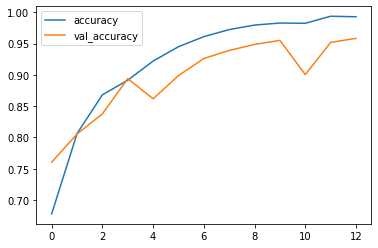

In [50]:
hist[["accuracy","val_accuracy"]].plot()

In [51]:
xtest=np.array(xtest).reshape(-1,100,100,1)

In [52]:
prediction=np.argmax(model.predict(xtest), axis=-1)

In [53]:
print(classification_report(prediction,ytest))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       518
           1       0.96      0.97      0.96       518

    accuracy                           0.96      1036
   macro avg       0.96      0.96      0.96      1036
weighted avg       0.96      0.96      0.96      1036



In [54]:
print(confusion_matrix(prediction,ytest))

[[495  23]
 [ 18 500]]
